Time series created with 31 data points
Date range: 2020-06-09 00:00:00 to 2025-06-02 00:00:00

Stationarity Test (Augmented Dickey-Fuller):
ADF Statistic: -1.580460
p-value: 0.493401
Series is non-stationary


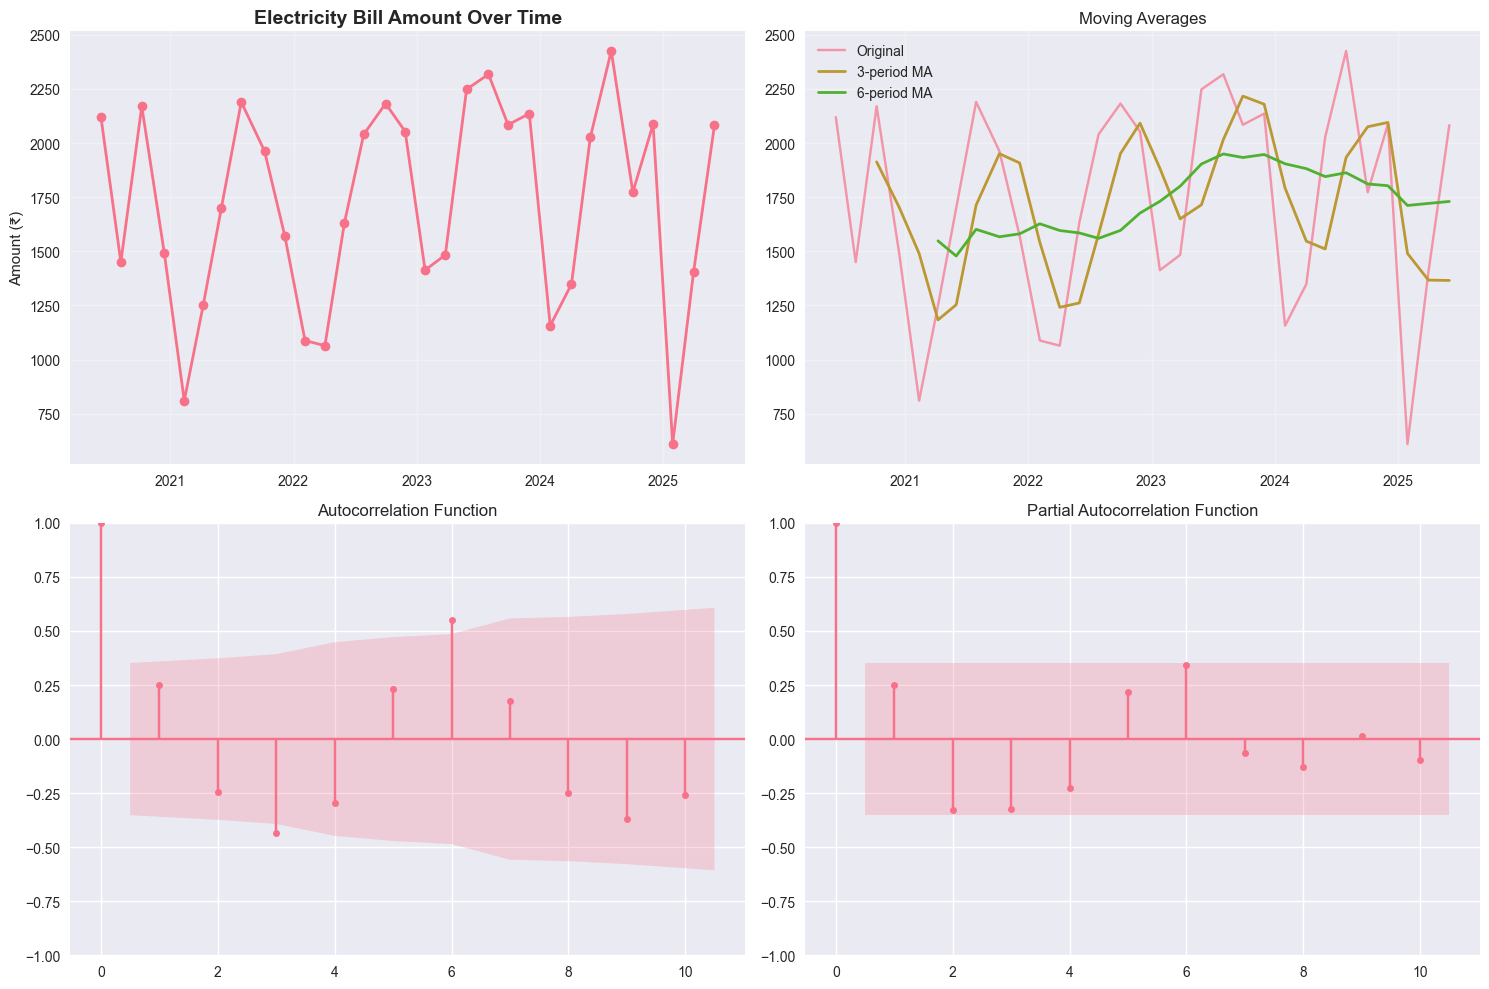

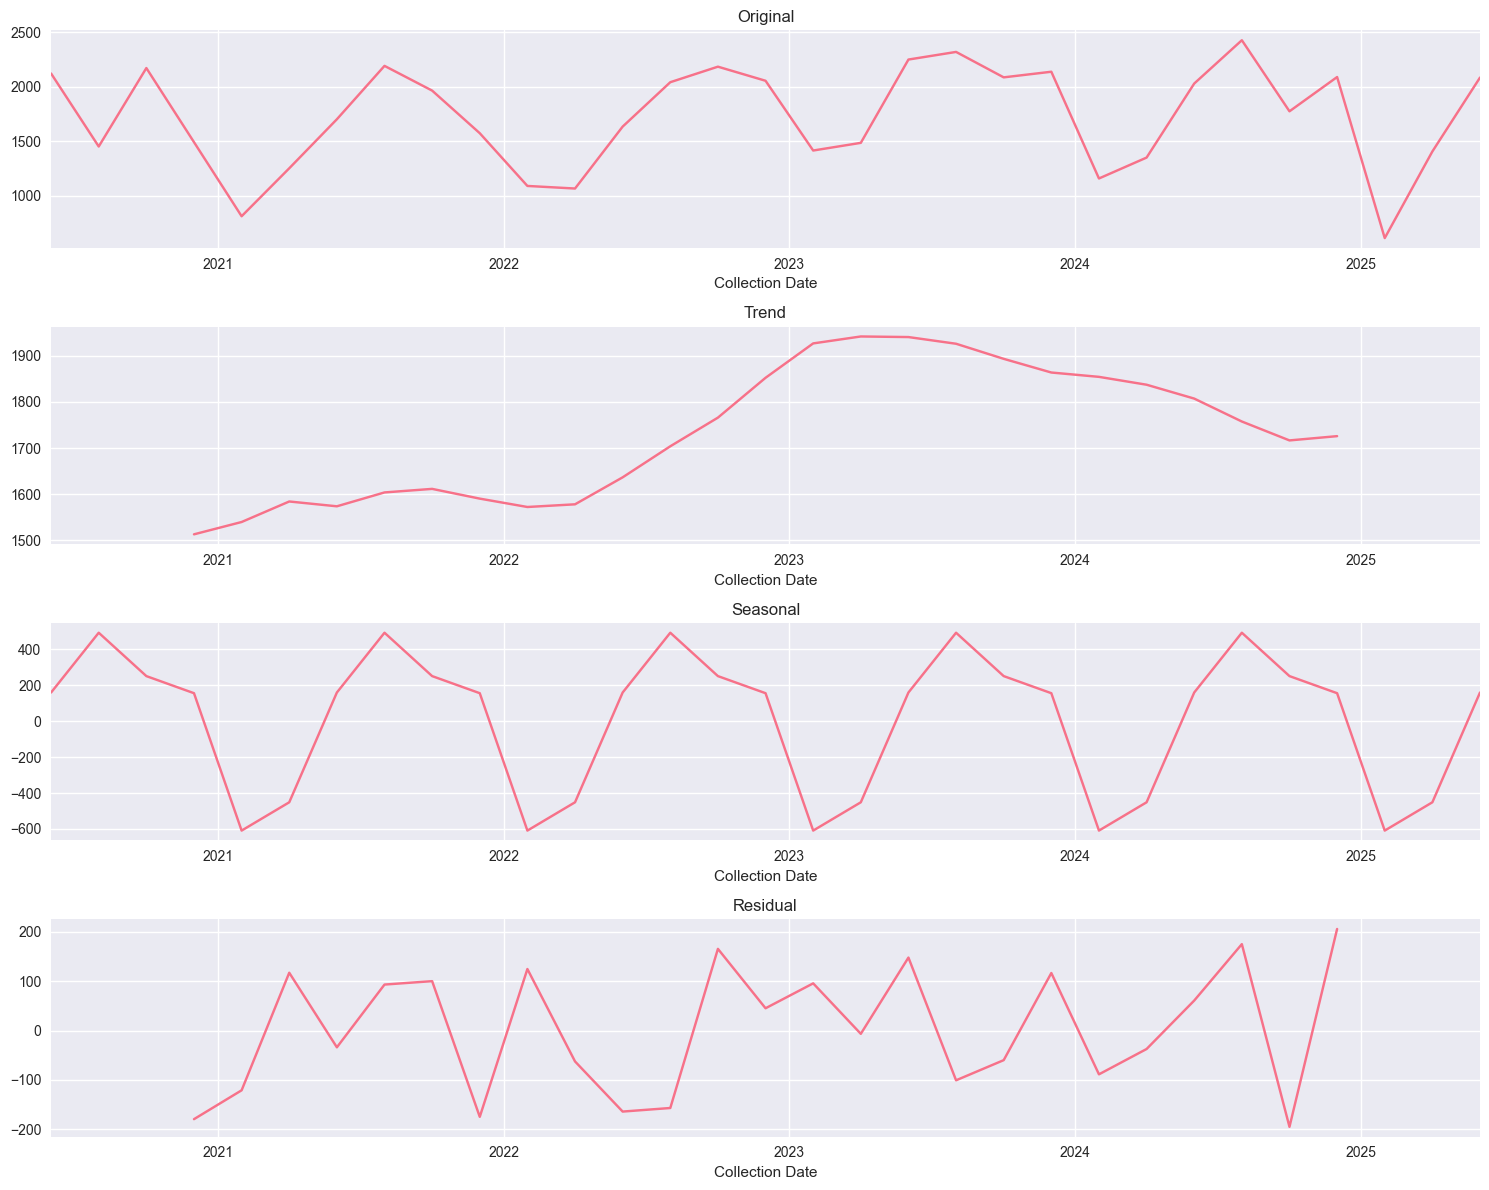


=== ARIMA Model ===
Best ARIMA parameters: (0, 1, 2)
AIC: 460.47
ARIMA Forecast: ₹1830.41

=== Exponential Smoothing ===
Exponential Smoothing Forecast: ₹2284.22

=== Simple Methods ===
Simple Moving Average: ₹1365.53
Weighted Moving Average: ₹1142.62
Linear Trend: ₹1300.69
Seasonal Adjusted: ₹1903.46

=== Ensemble Forecast ===
Ensemble Forecast: ₹1805.62
95% Confidence Interval: ₹1022.23 - ₹2589.01


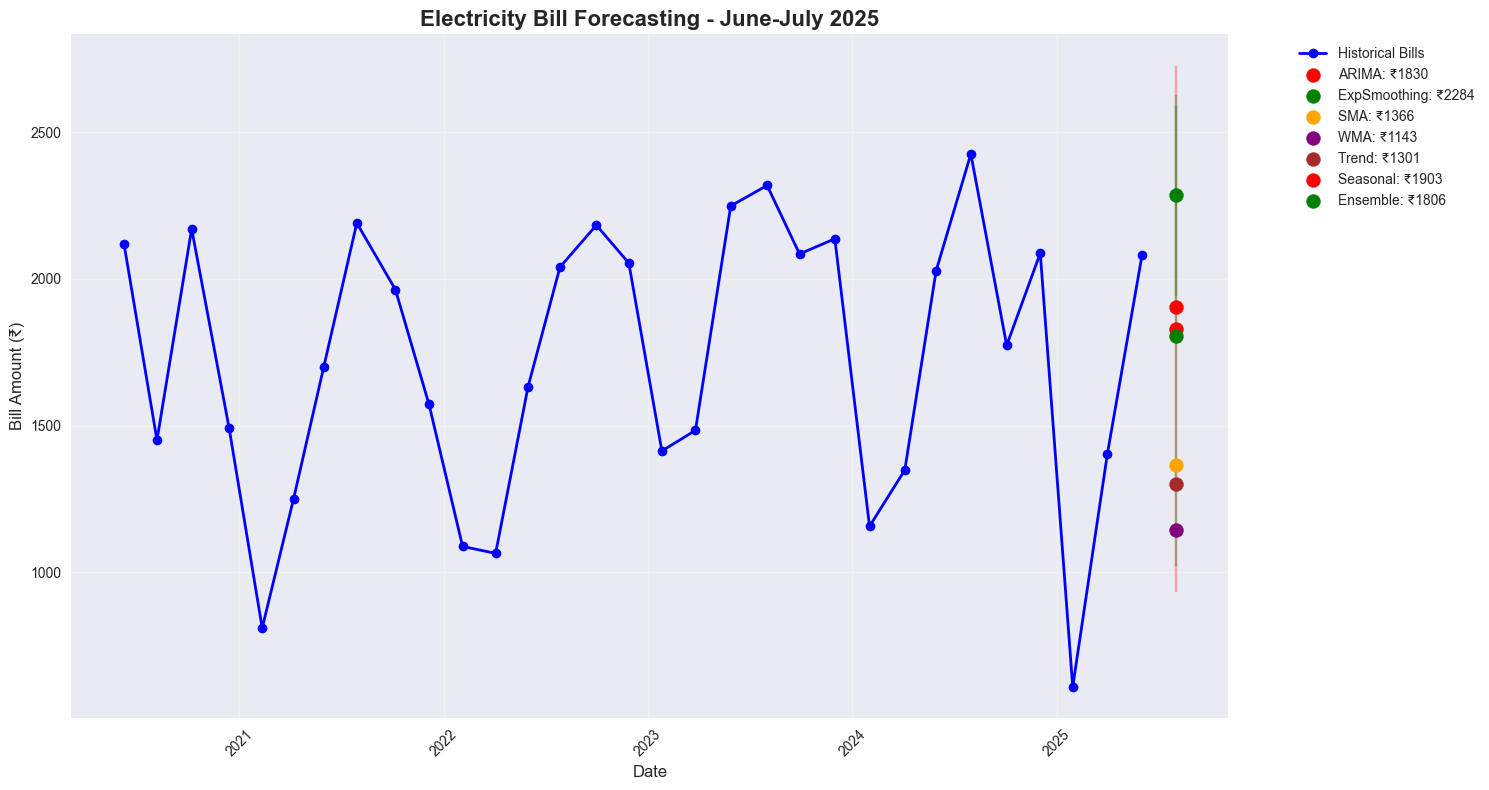


ELECTRICITY BILL FORECASTING SUMMARY REPORT

Historical Data Summary:
Total Bills Analyzed: 31
Date Range: 2020-06-09 to 2025-06-02
Average Bill: ₹1721.76
Median Bill: ₹1773.00
Highest Bill: ₹2425.36
Lowest Bill: ₹609.54
Standard Deviation: ₹477.72

Recent Trend Analysis:
Recent 6 bills average: ₹1730.42
Previous 6 bills average: ₹1845.23
Trend change: -6.2%

Forecasts for June-July 2025 Bill:
----------------------------------------
ARIMA          : ₹ 1830.41
                 (₹934.24 - ₹2726.59)
ExpSmoothing   : ₹ 2284.22
                 (₹1941.58 - ₹2626.85)
SMA            : ₹ 1365.53
WMA            : ₹ 1142.62
Trend          : ₹ 1300.69
Seasonal       : ₹ 1903.46
Ensemble       : ₹ 1805.62
                 (₹1022.23 - ₹2589.01)

🎯 RECOMMENDED FORECAST: ₹1805.62
💡 Suggested Budget (with 15% buffer): ₹2076.46



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

# Time series libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set style for better plots
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")

class ElectricityBillForecaster:
    def __init__(self, csv_data):
        self.df = self.load_and_clean_data(csv_data)
        self.ts_data = None
        self.models = {}
        self.forecasts = {}
        
    def load_and_clean_data(self, csv_data):
        """Load and clean the electricity bill data"""
        # Read CSV data
        df = pd.read_csv(StringIO(csv_data))
        
        # Clean column names
        df.columns = df.columns.str.strip()
        
        # Convert dates
        df['Bill Date'] = pd.to_datetime(df['Bill Date'])
        df['Collection Date'] = pd.to_datetime(df['Collection Date'])
        
        # Clean amount column
        df['Transaction Amount'] = pd.to_numeric(df['Transaction Amount'], errors='coerce')
        
        # Remove any rows with missing amounts
        df = df.dropna(subset=['Transaction Amount'])
        
        # Sort by collection date (this represents the billing period end)
        df = df.sort_values('Collection Date')
        
        return df
    
    def create_time_series(self):
        """Create time series with proper indexing"""
        # Use Collection Date as index since it represents when bill is paid
        # Each bill represents a 2-month period ending on the collection date
        self.ts_data = pd.Series(
            data=self.df['Transaction Amount'].values,
            index=pd.to_datetime(self.df['Collection Date']),
            name='Bill_Amount'
        )
        
        print(f"Time series created with {len(self.ts_data)} data points")
        print(f"Date range: {self.ts_data.index.min()} to {self.ts_data.index.max()}")
        
        return self.ts_data
    
    def analyze_stationarity(self):
        """Check if the time series is stationary"""
        result = adfuller(self.ts_data.dropna())
        print('\nStationarity Test (Augmented Dickey-Fuller):')
        print(f'ADF Statistic: {result[0]:.6f}')
        print(f'p-value: {result[1]:.6f}')
        
        if result[1] <= 0.05:
            print("Series is stationary")
            return True
        else:
            print("Series is non-stationary")
            return False
    
    def plot_time_series(self):
        """Plot the original time series and its components"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Original series
        axes[0,0].plot(self.ts_data.index, self.ts_data.values, marker='o', linewidth=2)
        axes[0,0].set_title('Electricity Bill Amount Over Time', fontsize=14, fontweight='bold')
        axes[0,0].set_ylabel('Amount (₹)')
        axes[0,0].grid(True, alpha=0.3)
        
        # Moving averages
        ma_3 = self.ts_data.rolling(window=3).mean()
        ma_6 = self.ts_data.rolling(window=6).mean()
        
        axes[0,1].plot(self.ts_data.index, self.ts_data.values, label='Original', alpha=0.7)
        axes[0,1].plot(ma_3.index, ma_3.values, label='3-period MA', linewidth=2)
        axes[0,1].plot(ma_6.index, ma_6.values, label='6-period MA', linewidth=2)
        axes[0,1].set_title('Moving Averages')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # ACF and PACF
        plot_acf(self.ts_data.dropna(), ax=axes[1,0], lags=10)
        axes[1,0].set_title('Autocorrelation Function')
        
        plot_pacf(self.ts_data.dropna(), ax=axes[1,1], lags=10)
        axes[1,1].set_title('Partial Autocorrelation Function')
        
        plt.tight_layout()
        plt.show()
    
    def seasonal_decomposition(self):
        """Perform seasonal decomposition"""
        try:
            # Resample to regular frequency if needed
            ts_regular = self.ts_data.resample('2M').mean().interpolate()
            
            if len(ts_regular) >= 8:  # Need at least 2 complete cycles
                decomposition = seasonal_decompose(ts_regular, model='additive', period=6)
                
                fig, axes = plt.subplots(4, 1, figsize=(15, 12))
                
                decomposition.observed.plot(ax=axes[0], title='Original')
                decomposition.trend.plot(ax=axes[1], title='Trend')
                decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
                decomposition.resid.plot(ax=axes[3], title='Residual')
                
                plt.tight_layout()
                plt.show()
                
                return decomposition
            else:
                print("Not enough data for seasonal decomposition")
                return None
        except Exception as e:
            print(f"Seasonal decomposition failed: {e}")
            return None
    
    def fit_arima_model(self):
        """Fit ARIMA model with automatic parameter selection"""
        print("\n=== ARIMA Model ===")
        
        try:
            # Try different ARIMA parameters
            best_aic = float('inf')
            best_params = None
            best_model = None
            
            # Parameter ranges to try
            p_range = range(0, 3)
            d_range = range(0, 2)
            q_range = range(0, 3)
            
            for p in p_range:
                for d in d_range:
                    for q in q_range:
                        try:
                            model = ARIMA(self.ts_data, order=(p, d, q))
                            fitted_model = model.fit()
                            
                            if fitted_model.aic < best_aic:
                                best_aic = fitted_model.aic
                                best_params = (p, d, q)
                                best_model = fitted_model
                        except:
                            continue
            
            if best_model:
                print(f"Best ARIMA parameters: {best_params}")
                print(f"AIC: {best_aic:.2f}")
                
                # Forecast next period
                try:
                    forecast_result = best_model.get_forecast(steps=1)
                    forecast = forecast_result.predicted_mean.iloc[0]
                    
                    # Get confidence intervals
                    conf_int = forecast_result.conf_int()
                    lower_ci = conf_int.iloc[0, 0]
                    upper_ci = conf_int.iloc[0, 1]
                except Exception as e:
                    print(f"Using alternative forecast method: {e}")
                    forecast = best_model.forecast(steps=1)
                    if hasattr(forecast, 'iloc'):
                        forecast = forecast.iloc[0]
                    elif hasattr(forecast, '__getitem__'):
                        forecast = forecast[0] if len(forecast) > 0 else float(forecast)
                    else:
                        forecast = float(forecast)
                    
                    lower_ci = forecast * 0.9
                    upper_ci = forecast * 1.1
                
                self.models['ARIMA'] = best_model
                self.forecasts['ARIMA'] = {
                    'forecast': forecast,
                    'lower_ci': lower_ci,
                    'upper_ci': upper_ci
                }
                
                print(f"ARIMA Forecast: ₹{forecast:.2f}")
                return best_model
            else:
                print("Could not fit ARIMA model")
                return None
                
        except Exception as e:
            print(f"ARIMA model failed: {e}")
            return None
    
    def fit_exponential_smoothing(self):
        """Fit Exponential Smoothing model"""
        print("\n=== Exponential Smoothing ===")
        
        try:
            # Try Holt-Winters with different configurations
            models_to_try = [
                {'seasonal': None, 'trend': 'add'},
                {'seasonal': None, 'trend': None},
                {'seasonal': 'add', 'trend': 'add', 'seasonal_periods': 6},
            ]
            
            best_aic = float('inf')
            best_model = None
            
            for config in models_to_try:
                try:
                    model = ExponentialSmoothing(self.ts_data, **config)
                    fitted_model = model.fit()
                    
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_model = fitted_model
                except:
                    continue
            
            if best_model:
                try:
                    forecast_result = best_model.forecast(steps=1)
                    
                    # Handle different types of forecast results
                    if hasattr(forecast_result, 'iloc'):
                        forecast = forecast_result.iloc[0]
                    elif hasattr(forecast_result, '__getitem__') and len(forecast_result) > 0:
                        forecast = forecast_result[0]
                    else:
                        forecast = float(forecast_result)
                    
                    self.models['ExpSmoothing'] = best_model
                    self.forecasts['ExpSmoothing'] = {
                        'forecast': forecast,
                        'lower_ci': forecast * 0.85,  # Approximate confidence interval
                        'upper_ci': forecast * 1.15
                    }
                    
                    print(f"Exponential Smoothing Forecast: ₹{forecast:.2f}")
                    return best_model
                    
                except Exception as e:
                    print(f"Error in exponential smoothing forecast: {e}")
                    return None
            else:
                print("Could not fit Exponential Smoothing model")
                return None
                
        except Exception as e:
            print(f"Exponential Smoothing failed: {e}")
            return None
    
    def simple_forecasting_methods(self):
        """Simple forecasting methods as baseline"""
        print("\n=== Simple Methods ===")
        
        recent_data = self.ts_data.tail(6).values  # Last 6 bills
        
        # Simple Moving Average
        sma_forecast = np.mean(recent_data[-3:])  # 3-period moving average
        
        # Weighted Moving Average (more weight to recent)
        weights = np.array([0.5, 0.3, 0.2])
        wma_forecast = np.average(recent_data[-3:], weights=weights)
        
        # Linear Trend
        x = np.arange(len(recent_data))
        coeffs = np.polyfit(x, recent_data, 1)
        trend_forecast = coeffs[0] * len(recent_data) + coeffs[1]
        
        # Seasonal adjustment (summer months typically higher)
        current_month = datetime.now().month
        if current_month in [4, 5, 6, 7, 8, 9]:  # Summer months
            seasonal_factor = 1.1
        else:
            seasonal_factor = 0.9
        
        seasonal_adjusted = np.mean(recent_data) * seasonal_factor
        
        self.forecasts['SMA'] = {'forecast': sma_forecast}
        self.forecasts['WMA'] = {'forecast': wma_forecast}
        self.forecasts['Trend'] = {'forecast': trend_forecast}
        self.forecasts['Seasonal'] = {'forecast': seasonal_adjusted}
        
        print(f"Simple Moving Average: ₹{sma_forecast:.2f}")
        print(f"Weighted Moving Average: ₹{wma_forecast:.2f}")
        print(f"Linear Trend: ₹{trend_forecast:.2f}")
        print(f"Seasonal Adjusted: ₹{seasonal_adjusted:.2f}")
    
    def ensemble_forecast(self):
        """Create ensemble forecast from multiple methods"""
        print("\n=== Ensemble Forecast ===")
        
        forecasts = []
        weights = []
        
        for method, result in self.forecasts.items():
            if 'forecast' in result:
                forecasts.append(result['forecast'])
                # Give more weight to advanced methods
                if method in ['ARIMA', 'ExpSmoothing']:
                    weights.append(0.3)
                else:
                    weights.append(0.1)
        
        if forecasts:
            # Normalize weights
            weights = np.array(weights) / np.sum(weights)
            ensemble_forecast = np.average(forecasts, weights=weights)
            
            # Calculate confidence interval
            forecast_std = np.std(forecasts)
            lower_ci = ensemble_forecast - 1.96 * forecast_std
            upper_ci = ensemble_forecast + 1.96 * forecast_std
            
            self.forecasts['Ensemble'] = {
                'forecast': ensemble_forecast,
                'lower_ci': lower_ci,
                'upper_ci': upper_ci
            }
            
            print(f"Ensemble Forecast: ₹{ensemble_forecast:.2f}")
            print(f"95% Confidence Interval: ₹{lower_ci:.2f} - ₹{upper_ci:.2f}")
            
            return ensemble_forecast
        
        return None
    
    def plot_forecasts(self):
        """Plot historical data with forecasts"""
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # Plot historical data
        ax.plot(self.ts_data.index, self.ts_data.values, 
                marker='o', linewidth=2, label='Historical Bills', color='blue')
        
        # Get next forecast date (assuming 2-month billing cycle)
        last_date = self.ts_data.index[-1]
        next_date = last_date + timedelta(days=60)  # Approximate 2-month cycle
        
        # Plot forecasts
        colors = ['red', 'green', 'orange', 'purple', 'brown']
        for i, (method, result) in enumerate(self.forecasts.items()):
            if 'forecast' in result:
                forecast_val = result['forecast']
                ax.scatter(next_date, forecast_val, 
                          s=100, color=colors[i % len(colors)], 
                          label=f'{method}: ₹{forecast_val:.0f}', zorder=5)
                
                # Add confidence interval if available
                if 'lower_ci' in result and 'upper_ci' in result:
                    ax.errorbar(next_date, forecast_val, 
                               yerr=[[forecast_val - result['lower_ci']], 
                                     [result['upper_ci'] - forecast_val]],
                               color=colors[i % len(colors)], alpha=0.3, capsize=5)
        
        ax.set_title('Electricity Bill Forecasting - June-July 2025', 
                     fontsize=16, fontweight='bold')
        ax.set_ylabel('Bill Amount (₹)', fontsize=12)
        ax.set_xlabel('Date', fontsize=12)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def summary_report(self):
        """Generate summary report"""
        print("\n" + "="*60)
        print("ELECTRICITY BILL FORECASTING SUMMARY REPORT")
        print("="*60)
        
        # Basic statistics
        print(f"\nHistorical Data Summary:")
        print(f"Total Bills Analyzed: {len(self.ts_data)}")
        print(f"Date Range: {self.ts_data.index.min().strftime('%Y-%m-%d')} to {self.ts_data.index.max().strftime('%Y-%m-%d')}")
        print(f"Average Bill: ₹{self.ts_data.mean():.2f}")
        print(f"Median Bill: ₹{self.ts_data.median():.2f}")
        print(f"Highest Bill: ₹{self.ts_data.max():.2f}")
        print(f"Lowest Bill: ₹{self.ts_data.min():.2f}")
        print(f"Standard Deviation: ₹{self.ts_data.std():.2f}")
        
        # Recent trend
        recent_6_avg = self.ts_data.tail(6).mean()
        older_6_avg = self.ts_data.iloc[-12:-6].mean() if len(self.ts_data) >= 12 else self.ts_data.head(6).mean()
        trend_change = ((recent_6_avg - older_6_avg) / older_6_avg) * 100
        
        print(f"\nRecent Trend Analysis:")
        print(f"Recent 6 bills average: ₹{recent_6_avg:.2f}")
        print(f"Previous 6 bills average: ₹{older_6_avg:.2f}")
        print(f"Trend change: {trend_change:+.1f}%")
        
        # Forecasts
        print(f"\nForecasts for June-July 2025 Bill:")
        print("-" * 40)
        for method, result in self.forecasts.items():
            if 'forecast' in result:
                forecast_val = result['forecast']
                print(f"{method:15s}: ₹{forecast_val:8.2f}")
                if 'lower_ci' in result and 'upper_ci' in result:
                    print(f"{'':15s}  (₹{result['lower_ci']:.2f} - ₹{result['upper_ci']:.2f})")
        
        # Recommendation
        if 'Ensemble' in self.forecasts:
            ensemble_val = self.forecasts['Ensemble']['forecast']
            print(f"\n🎯 RECOMMENDED FORECAST: ₹{ensemble_val:.2f}")
            
            # Budget planning
            buffer = ensemble_val * 0.15  # 15% buffer
            budget_amount = ensemble_val + buffer
            print(f"💡 Suggested Budget (with 15% buffer): ₹{budget_amount:.2f}")
        
        print("\n" + "="*60)

def main():
    # Your CSV data
    csv_data = """Sr.No.,Reciept no,Bill Date,Collection Date,Transaction Amount,Payment Type,Mode of Payment
1,BD015153BAHAAAPI4MY8,2025-05-02,2025-06-02,2082.68,Energy Charges,INSTA PAY
2,BD015091BAGAAANTVLDB,2025-03-01,2025-04-01,1404.38,Energy Charges,INSTA PAY
3,BD015029BAGAAAL12CJI,2024-12-29,2025-01-29,609.54,Energy Charges,INSTA PAY
4,BD014337BAFAAAKD8VZB,2024-11-02,2024-12-02,2087.56,Energy Charges,INSTA PAY
5,QF477134,2024-09-03,2024-10-03,1773.0,Energy Charges,CASH
6,BD014213BAEAAAF3X0QK,2024-06-30,2024-07-31,2425.36,Energy Charges,INSTA PAY
7,BD014151BADAAAD8FB4E,2024-04-30,2024-05-30,2027.82,Energy Charges,INSTA PAY
8,20757185371,2024-03-04,2024-04-04,1348.35,Energy Charges,INSTA PAY
9,20406018170,2024-01-01,2024-02-01,1156.51,Energy Charges,INSTA PAY
10,20094073250,2023-11-01,2023-12-01,2136.14,Energy Charges,INSTA PAY
11,19781106927,2023-08-29,2023-09-29,2084.58,Energy Charges,INSTA PAY
12,19488250821,2023-07-02,2023-08-02,2318.0,Energy Charges,INSTA PAY
13,18944656409,2023-04-29,2023-05-29,2248.0,Energy Charges,INSTA PAY
14,18404042407,2023-02-27,2023-03-27,1483.5,Energy Charges,INSTA PAY
15,15261870624,2022-12-26,2023-01-26,1413.1,Energy Charges,INSTA PAY
16,13095313465,2022-10-28,2022-11-28,2053.34,Energy Charges,INSTA PAY
17,11807371536,2022-09-01,2022-10-01,2182.6,Energy Charges,INSTA PAY
18,11171590790,2022-06-28,2022-07-28,2040.0,Energy Charges,INSTA PAY
19,10958307048,2022-05-01,2022-06-01,1632.62,Energy Charges,INSTA PAY
20,10762870341,2022-03-04,2022-04-04,1064.31,Energy Charges,INSTA PAY
21,9168851987,2022-01-04,2022-02-04,1088.05,Energy Charges,INSTA PAY
22,1652060412,2021-11-06,2021-12-06,1572.0,Energy Charges,CASH
23,1936174327,2021-09-07,2021-10-07,1963.0,Energy Charges,CASH
24,QY194192,2021-06-30,2021-07-30,2190.0,Energy Charges,CASH
25,QY132014,2021-05-01,2021-06-01,1700.0,Energy Charges,CASH
26,QY013744,2021-03-08,2021-04-08,1250.0,Energy Charges,CASH
27,QY043270,2021-01-11,2021-02-11,810.0,Energy Charges,CASH
28,QG496991,2020-11-14,2020-12-14,1490.0,Energy Charges,CASH
29,QG490559,2020-09-08,2020-10-08,2170.0,Energy Charges,CASH
30,SE134053,2020-07-07,2020-08-07,1450.0,Energy Charges,CASH
31,SE130525,2020-05-09,2020-06-09,2120.0,Energy Charges,CASH"""

    # Create forecaster instance
    forecaster = ElectricityBillForecaster(csv_data)
    
    # Create time series
    forecaster.create_time_series()
    
    # Analyze data
    forecaster.analyze_stationarity()
    
    # Plot time series
    forecaster.plot_time_series()
    
    # Seasonal decomposition
    forecaster.seasonal_decomposition()
    
    # Fit models and generate forecasts
    forecaster.fit_arima_model()
    forecaster.fit_exponential_smoothing()
    forecaster.simple_forecasting_methods()
    
    # Create ensemble forecast
    forecaster.ensemble_forecast()
    
    # Plot all forecasts
    forecaster.plot_forecasts()
    
    # Generate summary report
    forecaster.summary_report()

if __name__ == "__main__":
    main()